In [78]:
import cv2
from matplotlib import pyplot as plt

# Display source image

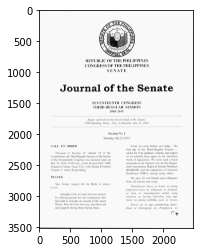

In [79]:
image = cv2.imread('journal-1-p0.png')
height, width, _ = image.shape
plt.imshow(image)

In [80]:
import layoutparser.models as lpmodel
import layoutparser.visualization as lpviz
from PIL import Image

model = lpmodel.Detectron2LayoutModel(
    config_path='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',  # In model catalog
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},  # In model`label_map`
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5]  # Optional
)

layout = model.detect(Image.fromarray(image))

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/home/devcsrj/.local/share/virtualenvs/klerk-6P6mTcQK/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


# Draw detected layout

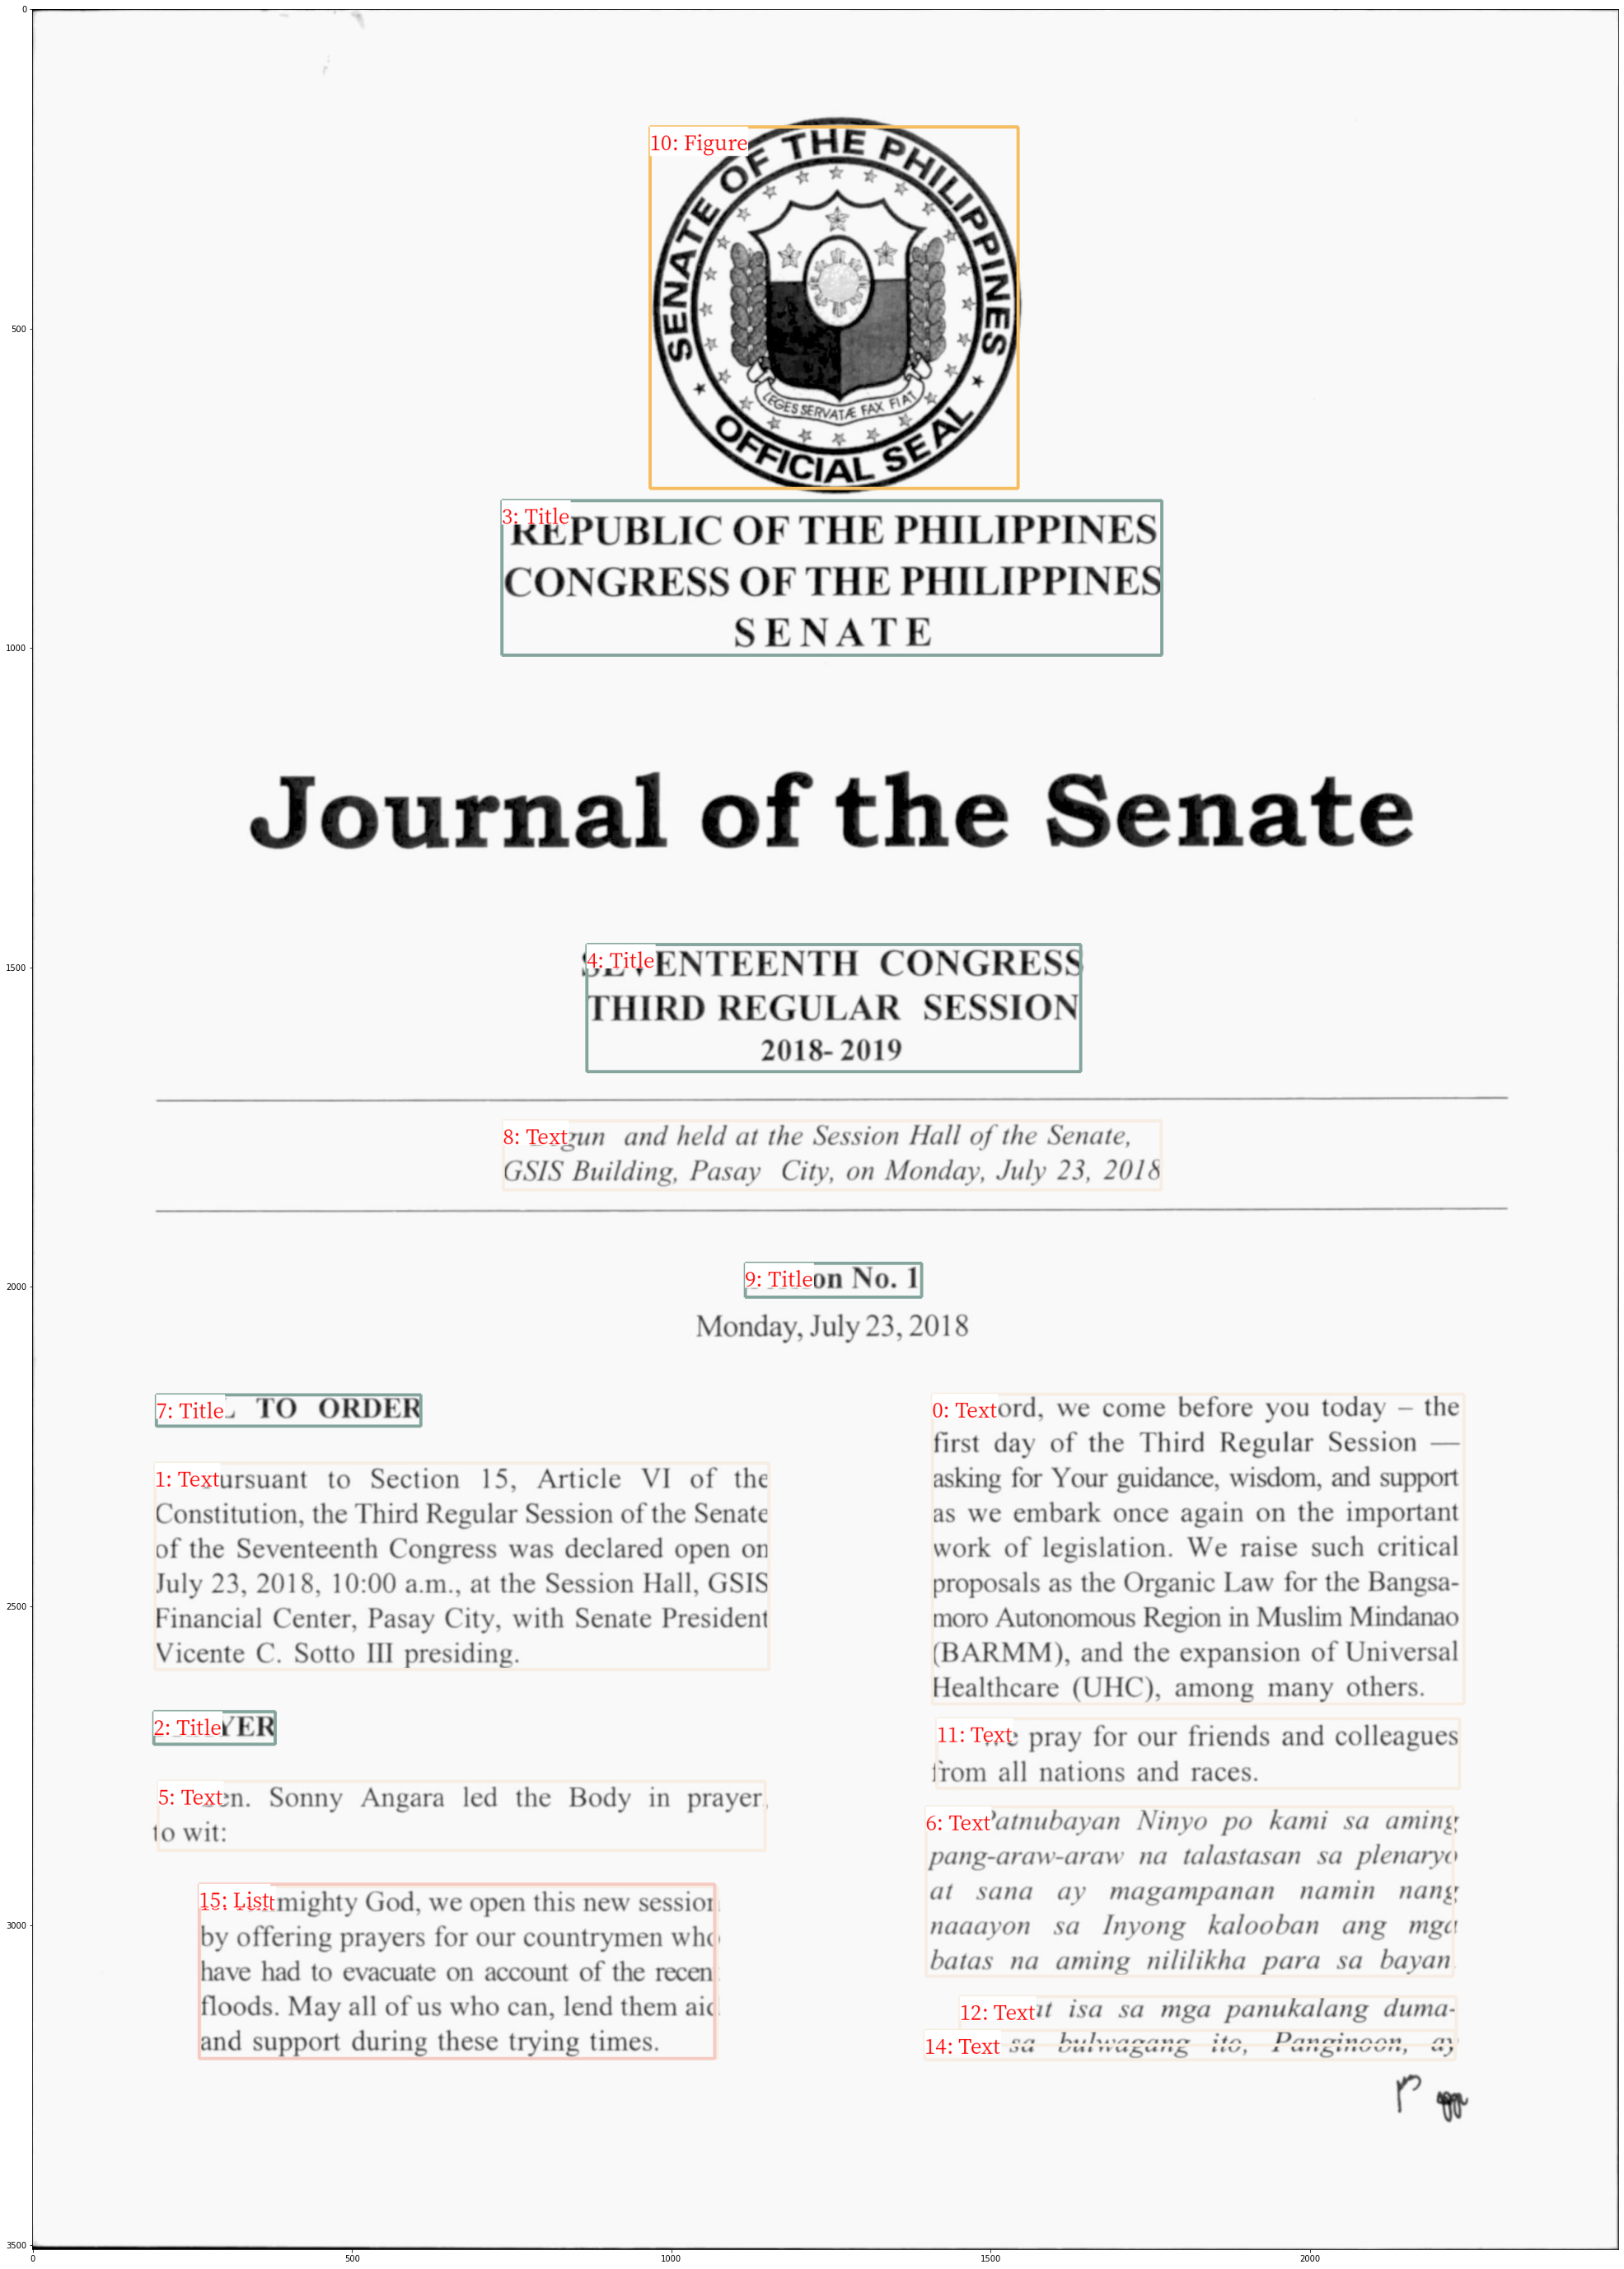

In [81]:
drawn = lpviz.draw_box(
    image,
    layout,
    box_width=5,
    id_font_size=32,
    id_text_color='red',
    show_element_id=True,
    show_element_type=True)

plt.figure(figsize=(50, 50))
plt.imshow(drawn)

# Run OCR

In [82]:
import layoutparser.ocr as lpocr

ocr_agent = lpocr.TesseractAgent()
sections = []
for layout_region in layout:
    image_segment = layout_region.crop_image(image)
    text = ocr_agent.detect(image_segment)
    sections.append({
        'region': layout_region,
        'image': image_segment,
        'text': text,
    })

# Post-Processing

In [83]:
from functools import cmp_to_key

blocks = list(map(lambda s: s['region'].block, sections))
left_most = min(blocks, key=lambda b: b.x_1)
right_most = max(blocks, key=lambda b: b.x_2)
x_margin = left_most.x_1 + (width - right_most.x_2)


def determine_column(x):
    """
    Returns the column at which the provided point is found

    :param x: the point in x axis
    :return: the column (0=left, 1=center, 2=right)
    """
    x = x - left_most.x_1  # offset left margin
    w = width - x_margin  # strip margin from total width

    #         left          middle        right
    cols = [w / 3, w / 2, w / 3 * 2]
    computed = list(map(lambda col: abs(x - col), cols))
    return computed.index(min(computed))


def compare_column(left, right):
    """
    Compares the two coordinates, and prioritizes those that are on top most,
    then left column, finally the right column.

    :returns the numerical priority
    """
    left_col = determine_column(left[0])
    right_col = determine_column(right[0])
    if left_col == right_col:
        return left[1] - right[1]  # compare y axis, closer to top wins
    if left_col == 1:
        return -1  # left wins
    if right_col == 1:
        return 1  # right wins
    return left_col - right_col

# Render results

In [84]:
by_column = lambda x, y: compare_column(x['region'].block.center,
                                        y['region'].block.center)
sections.sort(key=cmp_to_key(by_column))

for section in sections:
    center = section['region'].block.center[0]
    col = determine_column(center)
    print(col, section['text'])

1  

1 REPUBLIC OF THE PHILIPPINES
CONGRESS OF THE PHILIPPINES
SENATE

1 SEVENTEENTH CONGRESS
THIRD REGULAR SESSION
2018-2019

1 Begun and held at the Session Hall of the Senate,
GSIS Building, Pasay City, on Monday, July 23, 2018

1 Session No. 1

0 CALL TO ORDER

0 Pursuant to Section 15, Article VI of the
Constitution, the Third Regular Session of the Senate
of the Seventeenth Congress was declared open on
July 23, 2018, 10:00 a.m., at the Session Hall, GSIS
Financial Center, Pasay City, with Senate President
Vicente C. Sotto II] presiding.

0 PRAYER

0 Sen. Sonny Angara led the Body in prayer.
0 wit:

0 Almighty God, we open this new sessio1
by offering prayers for our countrymen wh¢
have had to evacuate on account of the recen
floods. May all of us who can, lend them aic
and support during these trying times.

0 Almighty God, we open this new sessior
by offering prayers for our countrymen whc
have had to evacuate on account of the recen'
floods. May all of us who can, le